In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install pytorch-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.7 MB/s eta 0:00:00


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from pytorch_transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [5]:
#%%---------Data Read & Transformation---------

#Data Reading for Davidson Dataset
nRowsRead = None # specify 'None' to read complete file
train_data  = pd.read_csv('Train-Augmentation.csv', delimiter=',', nrows = nRowsRead,encoding = "ISO-8859-1")
nRow, nCol = train_data.shape
print('There are {} rows and {} columns'.format(nRow, nCol))



There are 8577 rows and 2 columns


In [6]:
# Create taweet and label lists
tweets = train_data.tweet.values

In [7]:
train_tweets = [tweet + " [SEP] [CLS]" for tweet in tweets]
train_labels = train_data.label.values

In [8]:
# Read the validation dataset
validation_data = pd.read_csv('Validation.csv', delimiter=',', encoding="ISO-8859-1")
validation_tweets = validation_data.tweet.values
validation_labels = validation_data.label.values

In [9]:
from transformers import XLNetTokenizer
from keras.preprocessing.sequence import pad_sequences
import torch
import pandas as pd

In [10]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

 #Tokenize the tweets for training data
train_tokenized_texts = [tokenizer.tokenize(sent) for sent in train_tweets]
print("Tokenize the first training tweet:")
print(train_tokenized_texts[0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

Tokenize the first training tweet:
['▁', 'rt', '▁', '@', 'cur', 'ls', 'god', 'des', 's', ':', '▁being', '▁so', '▁wrapped', '▁up', '▁in', '▁love', '▁that', '▁you', '▁stop', '▁doing', '▁well', '▁for', '▁you', '▁is', '▁what', '▁middle', '▁school', 'ers', '▁do', ',', '▁dumb', '▁bitch', '.', '▁', 'i', '▁want', '▁just', '▁want', '▁mo', '&', '#', '82', '30', ';', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


In [11]:
# Tokenize the tweets for validation data
validation_tokenized_texts = [tokenizer.tokenize(sent) for sent in validation_tweets]
print("Tokenize the first validation tweet:")
print(validation_tokenized_texts[0])

Tokenize the first validation tweet:
['▁', 'rt', '▁', '@', 'am', 'g', 'll', 'cc', 'eo', ':', '▁social', '▁network', '▁got', '▁bitch', 'es', '▁heads', '▁like', '▁&', '#', '12', '85', '53', ';', '▁http', '://', 't', '.', 'co', '/', 'bh', 'mu', 'o', '4', 'x', '4', 'vu']


In [12]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
MAX_LEN = 256

In [13]:
# Convert tokens to input IDs for training and validation
train_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in train_tokenized_texts]
validation_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in validation_tokenized_texts]


In [14]:
# Pad the sequences for training and validation
train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
validation_input_ids = pad_sequences(validation_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [15]:
# Create attention masks for training and validation
train_attention_masks = [[float(i > 0) for i in seq] for seq in train_input_ids]
validation_attention_masks = [[float(i > 0) for i in seq] for seq in validation_input_ids]


In [16]:
# Convert to torch tensors
train_inputs = torch.tensor(train_input_ids)
validation_inputs = torch.tensor(validation_input_ids)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_attention_masks)
validation_masks = torch.tensor(validation_attention_masks)

print("Training and validation data loaded and processed successfully.")

Training and validation data loaded and processed successfully.


In [17]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [18]:
from pandas import to_datetime
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
# MUST INSTALL PYTORCH-TRANSFORMERS
from pytorch_transformers import XLNetTokenizer, XLNetForSequenceClassification, AdamW
from tqdm import trange
from numpy import argmax, sum
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
!pip install transformers

In [20]:
import torch
from transformers import XLNetForSequenceClassification

model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=3)

model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias','gamma','beta']
optimizer_grouped_parameters = [
    {'params':[p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate':0.01},
    {'params':[p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate':0.0}
]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top.

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=3)
model.cuda()

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [22]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=1e-5)

In [23]:
# Function to calculate the accuracy of our predictions vs labels
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1)
    labels_flat = labels
    return f1_score(labels_flat, preds_flat, average='macro')

def a_score(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

def p_score(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return precision_score(labels_flat, preds_flat, average='macro')

def r_score(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return recall_score(labels_flat, preds_flat, average='macro')
def flat_accuracy(labels_flat, pred_flat):
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [24]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):


  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))


  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  all_logits=[]
  all_labels=[]
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    all_logits.extend(np.argmax(logits, axis=1).flatten())
    all_labels.extend(label_ids)
  accuracy = accuracy_score(all_logits , all_labels)

    #tqdm.write(f'\nEpoch {epoch}')


    #loss_train_avg = loss_train_total/len(dataloader_train)
    #tqdm.write(f'Training loss: {loss_train_avg}')

   # val_loss, predictions, true_vals = evaluate(dataloader_validation)
  val_f1 = f1_score(all_logits, all_labels, average='macro')
  val_precision = precision_score(all_logits, all_labels, average='macro')
  val_recall = recall_score(all_logits, all_labels, average='macro')


  print("Validation Accuracy: {}".format(accuracy))
  print("Validation f1: {}".format(val_f1))

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1642.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Train loss: 0.6126705482325147


Epoch:  10%|█         | 1/10 [11:07<1:40:06, 667.35s/it]

Validation Accuracy: 0.8658372562205784
Validation f1: 0.731637687238999
Train loss: 0.30602274650922495


Epoch:  20%|██        | 2/10 [22:23<1:29:38, 672.32s/it]

Validation Accuracy: 0.8584398117014123
Validation f1: 0.73879692054602
Train loss: 0.26033442406516977


Epoch:  30%|███       | 3/10 [33:32<1:18:15, 670.79s/it]

Validation Accuracy: 0.8799596503026227
Validation f1: 0.762395202354546
Train loss: 0.2256655537395229


Epoch:  40%|████      | 4/10 [44:47<1:07:16, 672.76s/it]

Validation Accuracy: 0.8530598520511096
Validation f1: 0.7428064267781189
Train loss: 0.1949885117312457


Epoch:  50%|█████     | 5/10 [55:56<55:56, 671.40s/it]  

Validation Accuracy: 0.8043039677202422
Validation f1: 0.7104197394671159
Train loss: 0.17748284558021224


Epoch:  60%|██████    | 6/10 [1:07:12<44:51, 672.90s/it]

Validation Accuracy: 0.8365837256220578
Validation f1: 0.733662240344414
Train loss: 0.14557388755250514


Epoch:  70%|███████   | 7/10 [1:18:22<33:36, 672.02s/it]

Validation Accuracy: 0.8258238063214526
Validation f1: 0.71795996224827
Train loss: 0.12207495425672003


Epoch:  80%|████████  | 8/10 [1:29:38<22:26, 673.20s/it]

Validation Accuracy: 0.8493611297915266
Validation f1: 0.7394029814049715
Train loss: 0.09667483321391046


Epoch:  90%|█████████ | 9/10 [1:40:46<11:11, 671.49s/it]

Validation Accuracy: 0.8402824478816409
Validation f1: 0.7326466521243898
Train loss: 0.07685737845359793


Epoch: 100%|██████████| 10/10 [1:52:03<00:00, 672.31s/it]

Validation Accuracy: 0.8120376597175522
Validation f1: 0.7130611136029704


In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import precision_score,recall_score,accuracy_score, f1_score
def show_confusion(pred_label,label,nm):
  class_names=['Hate','Offensive','Neither']
  cm=confusion_matrix(pred_label,label)
  disp =ConfusionMatrixDisplay(cm,display_labels=class_names)
  disp.plot()
  plt.title(f'Confusion Matrix {nm}')
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.show()

In [26]:
def mymetrics(Y,P , alg = None):
    recall= recall_score(Y, P, average='macro')
    acc2= accuracy_score(Y, P)
    precision= precision_score(Y, P, average='macro')
    Fmeasure = f1_score(Y, P, average='macro')

===== : validation XLNET : =====


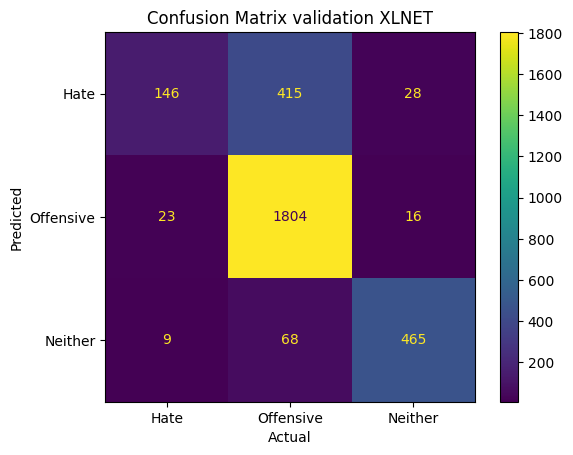

In [27]:
print("===== : validation XLNET : =====")
mymetrics(all_logits,all_labels,'validation XLNET')
show_confusion(all_logits,all_labels,'validation XLNET')

In [28]:
from sklearn.metrics import classification_report
c = classification_report(all_labels, all_logits, digits=4)
print(c)

              precision    recall  f1-score   support

           0     0.2479    0.8202    0.3807       178
           1     0.9788    0.7888    0.8736      2287
           2     0.8579    0.9136    0.8849       509

    accuracy                         0.8120      2974
   macro avg     0.6949    0.8409    0.7131      2974
weighted avg     0.9144    0.8120    0.8460      2974



In [29]:
#%%---------Data Read & Transformation---------

#Data Reading for Davidson Dataset
nRowsRead = None # specify 'None' to read complete file
test_data2 = pd.read_csv('Test.csv', delimiter=',', nrows = nRowsRead,encoding = "ISO-8859-1")
nRow, nCol = test_data2.shape
print('There are {} rows and {} columns'.format(nRow, nCol))


There are 4957 rows and 2 columns


In [30]:
# Create sentence and label lists
t = test_data2.tweet.values

In [31]:
t = [tweet + " [SEP] [CLS]" for tweet in t]
lab = test_data2.label.values

In [32]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in t]


In [33]:
MAX_LEN = 256

# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []


# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(lab)

batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [34]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.extend(np.argmax(logits, axis=1).flatten())
  true_labels.extend(label_ids)

In [35]:
from sklearn.metrics import classification_report
n = classification_report(true_labels,predictions, digits=4)
print(n)

              precision    recall  f1-score   support

           0     0.2249    0.6880    0.3389       234
           1     0.9773    0.8424    0.9048      3928
           2     0.8433    0.9069    0.8739       795

    accuracy                         0.8455      4957
   macro avg     0.6818    0.8125    0.7059      4957
weighted avg     0.9203    0.8455    0.8732      4957



===== : Test XLNET : =====


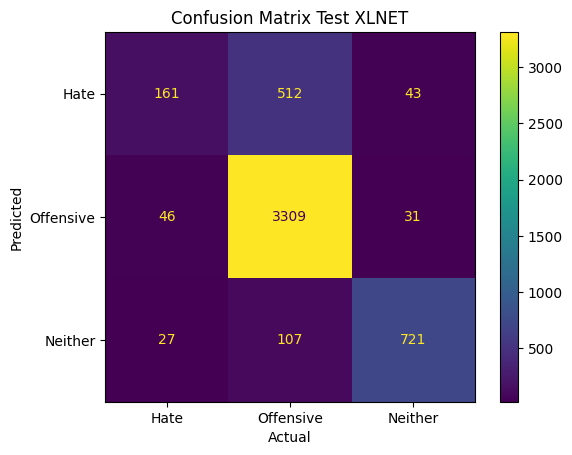

In [36]:
print("===== : Test XLNET : =====")
mymetrics(predictions,true_labels,'Test XLNET')
show_confusion(predictions,true_labels,'Test XLNET')

In [37]:
import pandas as pd

# ساختن دیتافریم شامل توییت‌ها، لیبل‌های واقعی و لیبل‌های پیش‌بینی شده
df_results = pd.DataFrame({
    'tweet': test_data2.tweet.values,  # توییت‌های تست
    'true_label': true_labels,         # لیبل‌های واقعی
    'predicted_label': predictions     # لیبل‌های پیش‌بینی شده توسط XLNet
})

# ذخیره در فایل CSV
df_results.to_csv('xlnet_test_predictions.csv', index=False, encoding='utf-8')

print("نتایج به فایل 'xlnet_predictions_with tweet.csv' ذخیره شد.")


نتایج به فایل 'xlnet_predictions_with tweet.csv' ذخیره شد.
